In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
url = '/content/drive/MyDrive/AI_05/Project/Section 1'
filename = '/vgames2.csv'
df = pd.read_csv(url+filename)
df = df.drop(df.columns[0], axis = 1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [11]:
df.shape

(16598, 9)

# 1.데이터 전처리 

##진행과정

0) 중첩 데이터 처리

1) sales 단위 수정

2) 연도 동일 양식으로 수정

3) 연도 missing value 처리

4) publisher 컬럼 중 unknown을 missing value로 처리하고 최대한 결측치를 처리 

5) genre 도 가능한 처리


In [12]:
# 0) 사전 단계로 중첩된 데이터를 삭제함. 

df.drop_duplicates(subset=['Name', 'Platform', 'Genre', 'Publisher', 'NA_Sales'], inplace = True)
df.shape

(16597, 9)

### 1) sales 단위 수정 / M 단위로 변경

In [13]:
# 함수 정의 
def data_cleaning(col) :
    tmp_data = []
    for i in col:

        try:
            tmp = float(i)
            tmp_data.append(tmp) 
        except: 
            if 'K' in i :
                if len(i) > 1 :
                    tmp= float(i.replace('K','')) / 1000
                    tmp_data.append(tmp)
            if 'M' in i :
                if len(i) > 1:
                    tmp= float(i.replace('M',''))
                    tmp_data.append(tmp)
    return tmp_data

In [14]:
# df에 적용
changes = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']

for i in changes:
    df[i] = data_cleaning(df[i])


###2) 연도 동일 양식으로 수정

In [15]:
# 함수 정의
def year_cleaning(x) :
    
    if 0<= x < 21 :
        x = str(x).split('.')[0]
        if len(x) == 1:
            year = '200' + x
            return float(year)
        elif len(x) == 2:
            year = '20' + x
            return float(year)
        else :
            return 'recheck'
    elif 21 < x <100:
        x = str(x).split('.')[0] 
        year = '19' + x
        return float(year)
    else:
        return x

In [16]:
# 함수 적용
df['Year'] = df['Year'].apply(year_cleaning)

In [17]:
# 중첩 데이터 재처리 -> 
df.drop_duplicates(subset=['Name', 'Platform', 'Genre', 'Publisher', 'NA_Sales'], inplace = True)
df.shape

(16597, 9)

###3) 연도 missing value 처리

In [18]:
# df를 year가 있는 df1과 year가 결측치인 df2로 나눔
# df1를 기준으로 df2의 year를 매꿈. 
# df1이 맞다는 전제가 있음. 

condition = (df['Year'].isna() == True)

df1 = df[~condition] 
df2 = df[condition]

print(df1.shape, df2.shape) 

(16327, 9) (270, 9)


In [20]:
#df1을 Name과 year만 뽑아서 결측값을 찾는 기준으로 사용(df1_ny)

df1_ny = df1[['Name', 'Year']]
df1_ny = df1_ny.drop_duplicates('Name', keep = 'last')
df1_ny.head()

,Name,Year
1,The Munchables,2009.0
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,2010.0
3,Deal or No Deal: Special Edition,2010.0
5,Power Pro Kun Pocket 8,2005.0
7,Samurai Warriors: State of War,2005.0


In [25]:
# Merge를 사용하여 df2를 기준으로 데이터를 합침. 

df1_ny.rename(columns= {'Year':'year'}, inplace = True) ## df2와 합칠 때 구별위해 변경

df2 = pd.merge(df2, df1_ny, how = 'left', on = 'Name')

(270, 10)

In [30]:
# df2에서 'Year'를 merge를 통해 찾은 year로 대체 후 year 열 삭제
df2['Year'] = df2['year']
df2.drop(columns = 'year', inplace = True)

In [31]:
# df1과 df2를 합쳐 다시 df 만듬

df = pd.concat([df1, df2], ignore_index = True)

In [32]:
df.isna().sum() # year 270 -> 146개로 결측치 감소

Name             0
Platform         0
Year           146
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [33]:
# 146개 year 결측치 중 정확히 찾아야 하는 것이 있는지 파악 필요.
# 국가별 sales를 하나로 합치고 전체 판매량이 상위 25%의 게임은 직접 찾아서 처리

df['G_sales'] = df[['NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales']].sum(axis = 1)

df.describe()

,Year,NA_Sales,EU_Sales,JP_Sales,Other_Sales,G_sales
count,16451.000000,16597.000000,16597.000000,16597.000000,16597.000000,16597.000000
mean,2006.411404,0.264683,0.146661,0.077785,0.048066,0.537195
std,5.816211,0.816705,0.505365,0.309300,0.188594,1.555192
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.110000,0.040000,0.040000,0.470000
max,2020.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [ ]:
# year가 결측치이고 G_sales가 0.47 이상인 게임 항목 찾기

con = ((df['Year'].isna() == True) & (df['G_sales'] >= 0.47))
df[con]

In [36]:
# 현재까지 정리한 파일을 csv로 추출하여 직접 찾기
df.to_csv('/content/drive/MyDrive/AI_05/Project/Section 1/vgames2_v01.csv')

In [38]:
# 수정 후 다시 csv 불러옴

url = '/content/drive/MyDrive/AI_05/Project/Section 1'
filename = '/vgames2_v011.csv'
df = pd.read_csv(url+filename)
df = df.drop(df.columns[0], axis = 1)
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,G_sales
0,1942,NES,1985.0,Shooter,Capcom,0.65,0.14,0.21,0.00,1.00
1,¡Shin Chan Flipa en colores!,DS,2007.0,Platform,505 Games,0.00,0.00,0.14,0.00,0.14
2,.hack: Sekai no Mukou ni + Versus,PS3,2012.0,Action,Namco Bandai Games,0.00,0.00,0.03,0.00,0.03
3,.hack//G.U. Vol.1//Rebirth,PS2,2006.0,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17
4,.hack//G.U. Vol.2//Reminisce,PS2,2006.0,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23


In [40]:
# 나머지 연도는 플랫폼을 기준으로 하여 각 플랫폼의 평균 연도를 사용
# 플랫폼은 시간이 지나면서 변경되기 때문에
# 다시 df를 나누고 합치는 과정 반복 

plat_y = df['Year'].groupby(by = df['Platform']).mean()
plat_y = round(plat_y, 0)
plat_y = pd.DataFrame(plat_y)
plat_y.rename(columns = {'Year': 'year'}, inplace = True)
plat_y.head()

con_py = df['Year'].isna() == True

df1 = df[~con_py]
df2 = df[con_py]

In [ ]:
df2 = pd.merge(df2, plat_y, how = 'left', on = 'Platform')
df2['Year'] = df2['year']
df2.drop('year', axis = 1, inplace = True)
df2.head()

In [42]:
df = pd.concat([df1, df2], ignore_index = True)
df.shape

(16597, 10)

In [43]:
df.isna().sum() # year는 모두 처리 완료함. 

Name            0
Platform        0
Year            0
Genre          49
Publisher      57
NA_Sales        0
EU_Sales        0
JP_Sales        0
Other_Sales     0
G_sales         0
dtype: int64

### 4) publisher 컬럼 중 unknown을 missing value로 처리하고 최대한 결측치를 처리

In [45]:
# publisher 중 Unknow을 Missing value 화
df["Publisher"] =df['Publisher'].replace(['Unknown'], np.nan)

# publisher 를 기준으로 다시 df를 분리 합치는 과정 진행

con_pu = (df['Publisher'].isna() == True)

df1 = df[~con_pu] 
df2 = df[con_pu]

# df1으로 기준 테이블 만들기 
df1_np = df1[['Name','Publisher']]
df1_np = df1_np.drop_duplicates(['Name'], keep = 'last')
df1_np.rename(columns = {'Publisher': 'pub'}, inplace = True)

# publisher nan 값 찾기 
df2 = pd.merge(df2, df1_np, how = 'left', on = 'Name')
df2['Publisher'] = df2['pub']
df2.drop('pub', axis = 1, inplace = True)

# df 복원
df = pd.concat([df1, df2], ignore_index=True)


In [ ]:
df.isna().sum(). # 처리 수 적음. 하지만 위에서 판매량 상위 25%는 직접 찾았기 때문에 추가로 작업은 하지 않음. 

### 5) genre 도 가능한 처리

In [48]:
# 위의 방식과 동일

con_gen = (df['Genre'].isna() == True)

df1 = df[~con_gen] 
df2 = df[con_gen]

# df1으로 기준 테이블 만들기 
df1_ng = df1[['Name','Genre']]
df1_ng = df1_ng.drop_duplicates(['Name'], keep = 'last')
df1_ng.rename(columns = {'Genre': 'gen'}, inplace = True)

# publisher nan 값 찾기 
df2 = pd.merge(df2, df1_ng, how = 'left', on = 'Name')
df2['Genre'] = df2['gen']
df2.drop('gen', axis = 1, inplace = True)

# df 복원
df = pd.concat([df1, df2], ignore_index=True)

In [50]:
df.isna().sum() # 49개에서 29개로 genre 결측치 감소

Name             0
Platform         0
Year             0
Genre           29
Publisher      194
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
G_sales          0
dtype: int64




# 질문: 지역에 따라 선호하는 게임 장르가 다를까?

## 미국 시장을 보자 

In [ ]:
# 미국 시장으로 df 만들기

df_na = df[df['NA_Sales']>0]
df_na = df_na[['Genre', 'NA_Sales']].dropna()
df_na.groupby('Genre').mean()

In [53]:
# one way ANOVA 실행

import statsmodels.api as sm
from statsmodels.formula.api import ols

model_na = ols('NA_Sales ~ Genre',                 # Model formula
            data = df_na).fit()
                
anova_result_na = sm.stats.anova_lm(model_na, typ=2)
print (anova_result_na)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


                sum_sq       df         F        PR(>F)
Genre        88.647430     11.0  9.242247  9.975443e-17
Residual  10519.309659  12064.0       NaN           NaN


In [ ]:
# ANOVA 가 95% 신뢰 수준 기준으로 유의미 하므로 귀무가설: 미국 시장의 장르 선호도는 같다를 기각하고
# 사후 검증을 통해 어떤 장르를 좋아하고 싫어하는지 파악함.

import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_na['NA_Sales'], df_na['Genre'])
post_hoc_res_na = comp.tukeyhsd()
post_hoc_res_na.summary() 

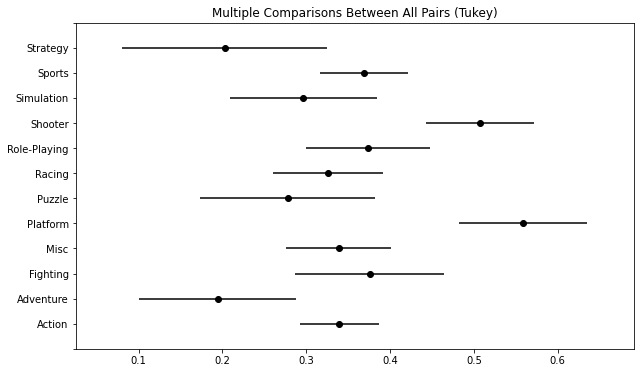

In [55]:
post_hoc_res_na.plot_simultaneous();

## 유럽시장

In [56]:
# 미국과 동일하게 진행

df_eu = df[df['EU_Sales']>0]
df_eu = df_eu[['Genre', 'EU_Sales']].dropna()
df_eu.groupby('Genre').mean()

model_eu = ols('EU_Sales ~ Genre',                 # Model formula
            data = df_eu).fit()
                
anova_result_eu = sm.stats.anova_lm(model_eu, typ=2)
print (anova_result_eu)

               sum_sq       df         F        PR(>F)
Genre       19.276859     11.0  4.743127  2.647062e-07
Residual  4004.682323  10839.0       NaN           NaN


In [ ]:
# 사후 검정(귀무 가설 기각)
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_eu['EU_Sales'], df_eu['Genre'])
post_hoc_res_eu = comp.tukeyhsd()
post_hoc_res_eu.summary() 

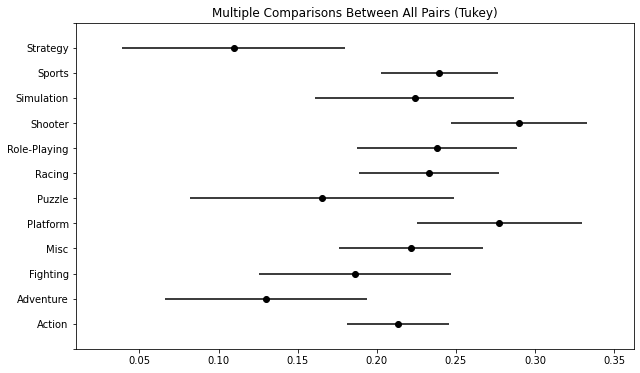

In [58]:
post_hoc_res_eu.plot_simultaneous();

## 일본 시장

In [59]:
# 일본 시장을 보자
df_jp = df[df['JP_Sales']>0]
df_jp = df_jp[['Genre', 'JP_Sales']].dropna()
df_jp.groupby('Genre').mean()

model_jp = ols('JP_Sales ~ Genre',                 # Model formula
            data = df_jp).fit()
                
anova_result_jp = sm.stats.anova_lm(model_jp, typ=2)
print (anova_result_jp)

               sum_sq      df          F        PR(>F)
Genre       64.257008    11.0  26.977717  1.120842e-55
Residual  1324.527879  6117.0        NaN           NaN


In [ ]:
# 사후 검정(귀무 가설 기각)
import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(df_jp['JP_Sales'], df_jp['Genre'])
post_hoc_res_jp = comp.tukeyhsd()
post_hoc_res_jp.summary() 

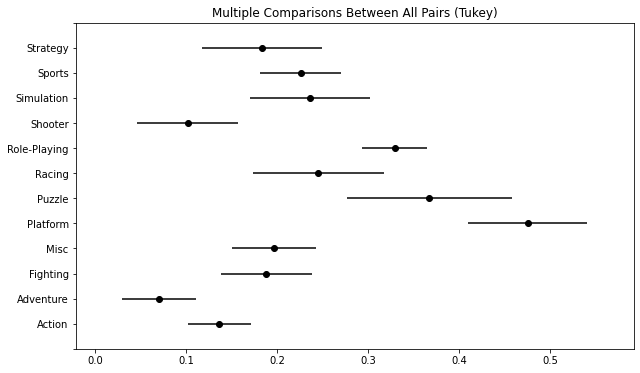

In [61]:
post_hoc_res_jp.plot_simultaneous();

## 기타 다른 나라

In [62]:
df_ot = df[df['Other_Sales']>0]
df_ot = df_ot[['Genre', 'Other_Sales']].dropna()
df_ot.groupby('Genre').mean()

model_ot = ols('Other_Sales ~ Genre',                 # Model formula
            data = df_ot).fit()
                
anova_result_ot = sm.stats.anova_lm(model_ot, typ=2)
print (anova_result_ot)

              sum_sq       df         F        PR(>F)
Genre       3.531015     11.0  5.803799  1.916000e-09
Residual  558.232010  10093.0       NaN           NaN


In [ ]:
comp = mc.MultiComparison(df_ot['Other_Sales'], df_ot['Genre'])
post_hoc_res_ot = comp.tukeyhsd()
post_hoc_res_ot.summary() 

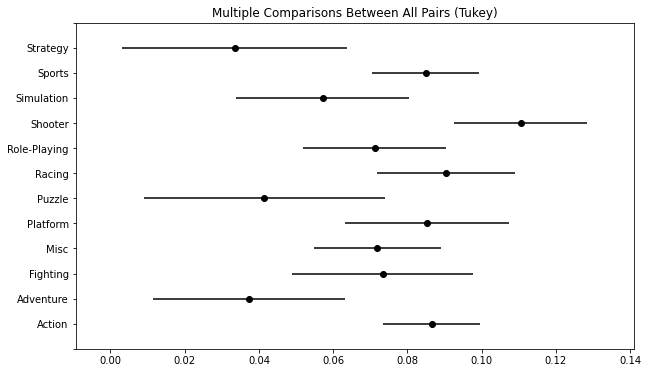

In [64]:
post_hoc_res_ot.plot_simultaneous();

# 질문2: 연도별 게임의 트렌드가 있을까?

1. 연도별 판매량으로 보는 장르 트렌드?

2. 출시되는 게임을 통한 트렌드 분석

3. 플랫폼도 트렌드가 있을까?

## 1. 연도별 판매량으로 보는 장르 트렌드?


In [66]:
# 피벗 테이블을 통해 데이터 정리
## 총 판매량 기준으로 알아봄

trend1 = pd.pivot_table(df, index = 'Year', columns = 'Genre', values = 'G_sales')
trend1 = trend1.fillna(0)
trend1 = trend1.iloc[0:-2] # 2017년 2020년 자료 문제로 삭제함.

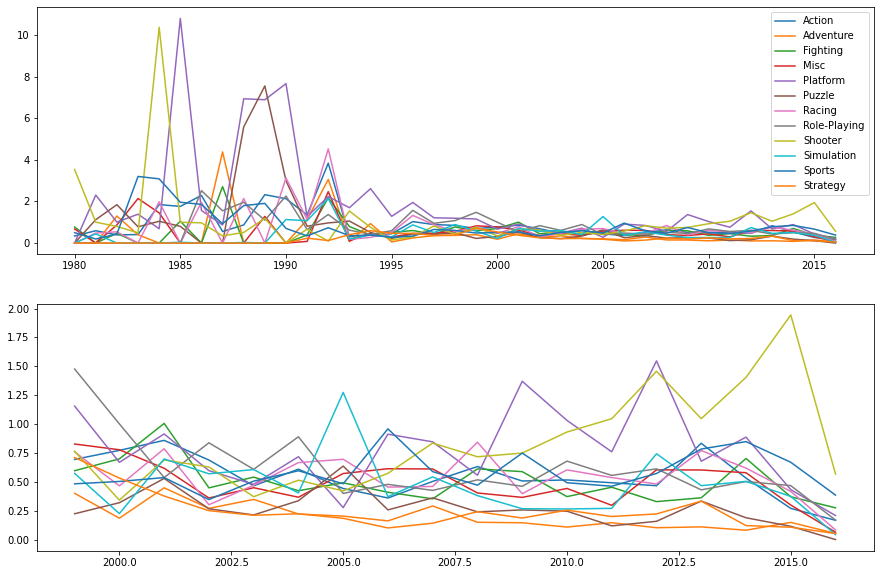

In [67]:
# 시각화를 통해 알아보기

fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(2,1,1) 
ax1.plot(trend1);
ax1.legend(trend1.columns)

ax2 = fig.add_subplot(2,1,2)
ax2.plot(trend1.iloc[19:]);

##2.출시되는 게임을 통한 트렌드 분석

In [77]:
trend2 = pd.crosstab(df.Year, df.Genre)
trend2 = trend2.iloc[0:-2]

In [79]:
trend2.tail()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
2012.0,272,58,29,38,12,11,30,78,50,18,54,15
2013.0,151,61,20,43,37,3,17,71,60,19,53,19
2014.0,186,75,23,41,10,8,27,92,47,11,55,8
2015.0,253,54,21,39,14,6,19,78,34,15,62,17
2016.0,119,34,14,18,10,0,20,40,32,9,38,10


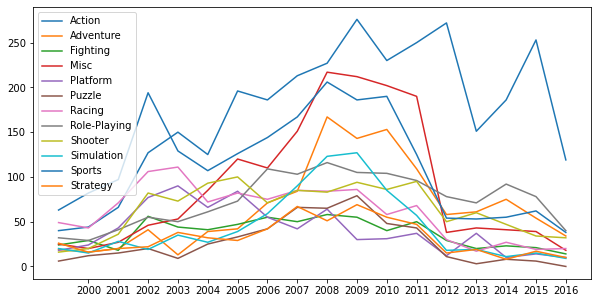

In [80]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1) 
ax.plot(trend2.iloc[19:]);
ax.legend(labels=trend2.columns);
ax.set_xticks(trend2.index[20:])
plt.show()

## 3. 플랫폼도 트렌드가 있을까?

In [94]:
trend3 = pd.pivot_table(df, index = 'Year', columns = 'Platform', values = 'G_sales')
trend3 = trend3.fillna(0)
# trend3 = trend3[20:-2]
trend3.head()

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1980.0,1.264444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1981.0,0.775652,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1982.0,0.708654,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1983.0,0.530909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.826667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1984.0,0.270000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.852308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [95]:
trend3 = trend3.iloc[20:-2]
trend3

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000.0,0.00,0.0,0.020000,0.29950,0.000000,1.162353,0.070000,0.000000,0.0,0.0,0.566167,0.0,0.0,0.664286,0.0,0.605975,0.477683,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.34,0.000000,0.000000,0.000000,0.990000,0.000000
2001.0,0.00,0.0,0.000000,0.13375,0.000000,0.924000,0.575047,1.157391,0.0,0.0,0.361111,0.0,0.0,0.366667,0.0,0.391099,0.899622,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.14,0.000000,0.000000,0.000000,0.671765,0.000000
2002.0,2.53,0.0,0.000000,0.29000,0.000000,0.000000,0.374545,0.339091,0.0,0.0,0.080000,0.0,0.0,0.451053,0.0,0.333500,0.731958,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.304132,0.000000
2003.0,0.00,0.0,0.000000,0.00000,0.000000,0.000000,0.380063,0.338618,0.0,0.0,0.000000,0.0,0.0,0.263529,0.0,0.690000,0.748256,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.294450,0.000000
2004.0,0.00,0.0,0.000000,0.00000,0.756957,0.000000,0.445200,0.343929,0.0,0.0,0.330000,0.0,0.0,0.335161,0.0,0.000000,0.817799,0.000000,0.000000,0.472667,0.000000,0.0,0.0,0.0,0.0,0.00,0.000000,0.000000,0.000000,0.362270,0.000000
2005.0,0.00,0.0,0.000000,0.00000,1.112712,0.000000,0.257445,0.284796,0.0,0.0,0.000000,0.0,0.0,0.116053,0.0,0.000000,0.601036,0.915000,0.000000,0.455464,0.000000,0.0,0.0,0.0,0.0,0.00,2.110000,0.000000,0.534545,0.272722,0.000000
2006.0,0.00,0.0,0.000000,0.00000,0.599010,0.000000,0.136500,0.281707,0.0,0.0,0.000000,0.0,0.0,0.055962,0.0,0.000000,0.396350,0.769286,0.000000,0.295417,0.000000,0.0,0.0,0.0,0.0,0.00,2.935833,0.000000,0.554574,0.161935,0.000000
2007.0,0.00,0.0,0.000000,0.02000,0.395026,0.000000,0.566667,0.067500,0.0,0.0,0.000000,0.0,0.0,0.148413,0.0,0.000000,0.353953,0.820778,0.000000,0.353926,0.000000,0.0,0.0,0.0,0.0,0.00,0.822328,0.000000,0.778780,0.183333,0.000000
2008.0,0.00,0.0,0.000000,0.04000,0.289845,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.163247,0.0,0.000000,0.282199,0.857643,0.000000,0.351714,0.000000,0.0,0.0,0.0,0.0,0.00,0.631538,0.000000,0.928435,0.180000,0.000000


In [96]:
trend3.drop( columns =['2600','3DO', 'DC','GEN', 'GG', 'NES', 'NG', 'PCFX', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'XB'], inplace = True )

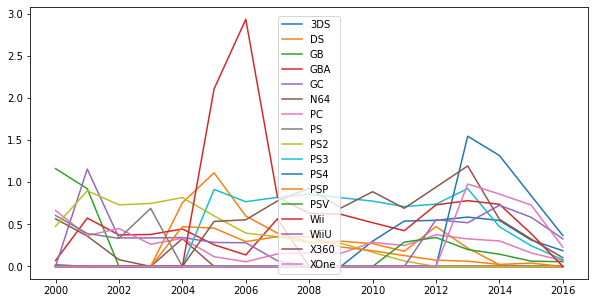

In [97]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1) 
ax.plot(trend3);
ax.legend(labels=trend3.columns);
# ax.set_xticks(trend3.index)
plt.show()

# 질문3: 출고량이 높은 게임에 대한 분석 

2012~2016년 간 출고량 top 5 를 선정하여 분석 진행

In [98]:
#2012
top_12 = df[df['Year'] == 2012]
top_12 = top_12['G_sales'].groupby(top_12['Name']).sum()
top_12 = pd.DataFrame(top_12)
top_12 = top_12.sort_values(by = 'G_sales', ascending = False)
top_12 = top_12.iloc[0:5]
top_12['year'] = 2012

In [99]:
#2013
top_13 = df[df['Year'] == 2013]
top_13 = top_13['G_sales'].groupby(top_13['Name']).sum()
top_13 = pd.DataFrame(top_13)
top_13 = top_13.sort_values(by = 'G_sales', ascending = False)
top_13 = top_13.iloc[0:5]
top_13['year'] = 2013

In [100]:
#2014
top_14 = df[df['Year'] == 2014]
top_14 = top_14['G_sales'].groupby(top_14['Name']).sum()
top_14 = pd.DataFrame(top_14)
top_14 = top_14.sort_values(by = 'G_sales', ascending = False)
top_14 = top_14.iloc[0:5]
top_14['year'] = 2014

In [101]:
#2015
top_15 = df[df['Year'] == 2015]
top_15 = top_15['G_sales'].groupby(top_15['Name']).sum()
top_15 = pd.DataFrame(top_15)
top_15 = top_15.sort_values(by = 'G_sales', ascending = False)
top_15 = top_15.iloc[0:5]
top_15['year'] = 2015

In [102]:
#2016
top_16 = df[df['Year'] == 2016]
top_16 = top_16['G_sales'].groupby(top_16['Name']).sum()
top_16 = pd.DataFrame(top_16)
top_16 = top_16.sort_values(by = 'G_sales', ascending = False)
top_16 = top_16.iloc[0:5]
top_16['year'] = 2016

In [103]:
# 2012~16년 자료 취합
## Genre, publisher 추가 진행 

top5 = pd.concat([top_12, top_13, top_14, top_15, top_16])

df_table = df.drop_duplicates(subset=['Name'], keep = 'last')
df_table = df_table[['Name', 'Genre', 'Publisher']]
top5 = pd.merge(top5, df_table, how = 'left', on = 'Name') 

In [104]:
top5

,Name,G_sales,year,Genre,Publisher
0,Call of Duty: Black Ops II,29.73,2012,Shooter,Activision
1,FIFA Soccer 13,16.15,2012,Action,Electronic Arts
2,Assassin's Creed III,13.10,2012,Action,Ubisoft
3,New Super Mario Bros. 2,9.83,2012,Platform,Nintendo
4,Halo 4,9.76,2012,Shooter,Microsoft Game Studios
5,Grand Theft Auto V,37.77,2013,Action,Take-Two Interactive
6,Call of Duty: Ghosts,27.37,2013,Shooter,Activision
7,FIFA 14,17.16,2013,Sports,Electronic Arts
8,Pokemon X/Pokemon Y,14.35,2013,NaN,Nintendo
9,Battlefield 4,14.04,2013,Shooter,Electronic Arts


In [105]:
# 자료 검토를 통해 FIFA Soccer 13 장르 수정 , Pokemon X/Pokemon Y 장르 입력
top5.iloc[1,3] = 'Sports'
top5.iloc[8,3] = 'Role-Playing'

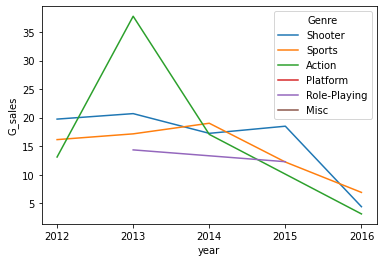

In [106]:
# 장르 분석

import seaborn as sns

ax = sns.lineplot(x='year', y='G_sales',hue='Genre', data=top5, ci = None)

plt.xticks([2012,2013,2014,2015,2016]) 
plt.show()

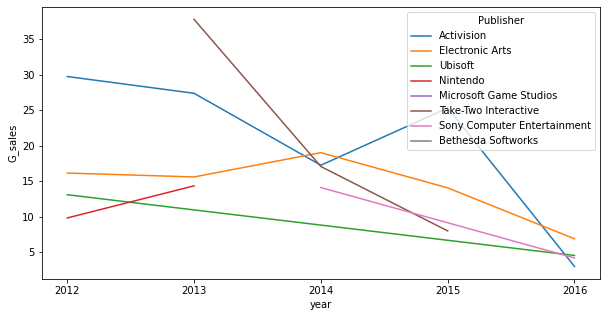

In [107]:
# publisher 분석
import seaborn as sns
fig = plt.figure(figsize=(10,5))

ax = sns.lineplot(x='year', y='G_sales',hue='Publisher', data=top5, ci = None)

plt.xticks([2012,2013,2014,2015,2016]) 
plt.show()

In [113]:
publisher = top5['Name'].groupby(top5['Publisher'])
publisher.size()

Publisher
Activision                     6
Bethesda Softworks             1
Electronic Arts                7
Microsoft Game Studios         1
Nintendo                       2
Sony Computer Entertainment    2
Take-Two Interactive           3
Ubisoft                        3
Name: Name, dtype: int64

In [119]:
genre = top5['Name'].groupby(top5['Genre'])
gen = genre.size()
gen

Genre
Action           4
Misc             1
Platform         1
Role-Playing     2
Shooter         11
Sports           6
Name: Name, dtype: int64

In [129]:
df_gen = pd.DataFrame(gen)
# df_gen.columns = ['Genre','num']
df_gen.reset_index(inplace = True)

In [140]:
df_gen = df_gen.rename(columns = {'Name': 'num'})

In [141]:
df_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Genre   6 non-null      object
 1   num     6 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 224.0+ bytes


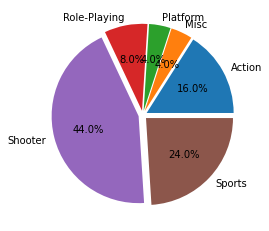

In [146]:
# 원그래프 그리기

explode = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

plt.pie(df_gen['num'], labels=df_gen['Genre'],autopct='%.1f%%',explode=explode)
plt.show()